In [1]:
import re
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import warnings
from nltk.corpus import stopwords
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

#https://na80.lightning.force.com/lightning/r/Report/00O1P000003mYjbUAE/view

/Users/emeryames/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def flatten(texts):
    return [word for sublist in texts for word in sublist]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
stop_words = stopwords.words('english')

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [3]:
#lexicon with all registered user's names
names_lex = pd.read_csv('name_lexicon.csv')
names_list = names_lex.values.tolist()
names = remove_stopwords(names_list)
names = flatten(names)

In [17]:
df = pd.read_csv('august_data.csv')
#df = pd.read_csv('year_data.csv')
df.Description.head()

0    Chat transcript\n\n\t\t\tE-mail: bistro@tohu.c...
1    Chat transcript\n\n\t\t\tName: Rebekkah Damian...
2    Chat transcript\n\n\t\t\tE-mail: jaycen@me.com...
3    Chat transcript\n\n\t\t\tE-mail: mario@elevati...
4    Chat transcript\n\n\t\t\tE-mail: opnaples@came...
Name: Description, dtype: object

In [18]:
data = df.Description.values.tolist()
data = [re.sub('\S*@\S*\s?', "", sent) for sent in data]
data = [re.sub('\s+', " ", sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('https:\S+',"", sent) for sent in data]
data = [re.sub('Chat transcript',"", sent) for sent in data]
data = [re.sub('BevSpot Support here! How can we help',"", sent) for sent in data]
data = [re.sub('Chat has been opened from',"", sent) for sent in data]
data = [re.sub('E-mail', "", sent) for sent in data]
data = [re.sub('..:..:.. ..', "", sent) for sent in data]
data = [re.sub('America\S+', "", sent) for sent in data]
data = [re.sub('\S+.com\S+', "", sent) for sent in data]
data = [re.sub('BevSpot', "", sent) for sent in data]

#manual stemming
data = [re.sub('invoices', "invoice", sent) for sent in data]
data = [re.sub('items', "item", sent) for sent in data]
data = [re.sub('reports', "report", sent) for sent in data]
data = [re.sub('orders', "order", sent) for sent in data]
data = [re.sub('recipes', "recipe", sent) for sent in data]

data_words = list(sent_to_words(data))

In [19]:
#updating stopwords
stop_words.extend (('chat','let','go','see','thank','get','done','email','take','look','hang','tight','show','reach','send','thanks',
                    'im','one','help','went','said','hi','gm','way','best','need','one','got','much','want','check','youll','sure',
                    'hello','hear','us','name','ok','okay','archived','yes','no','well','like','would','link','list','ill','ive',
                    'mon','tue','wed','thu','fri','gingrich','janeth','youre','th','jaycen','blendi','suvaria','great','says','set','ya',
                    'ocean','prime','roisman','casabona','rebekkah','almodovar','awesome','lets',
                    'erick','victoria','marguerite','dan'))
stop_words.extend(names)

In [20]:
#final clean
data_words_nostops = remove_stopwords(data_words)

#modeling
bigram = gensim.models.Phrases(data_words_nostops, min_count=2, threshold=1) #changed data_words to data_words_nostops
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#transforming
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

data = data_words_bigrams #edit for bi or tri
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

In [29]:
#clustering
num_topics = 9
chunksize = 200 
passes = 30 
iterations = 1000
eval_every = 1 

lda_model = LdaModel(corpus=corpus,
    id2word=id2word,
    num_topics = num_topics, 
    random_state = 100,
    update_every = eval_every,
    chunksize=chunksize,
    eta = 'auto',
    passes = passes,
    iterations = iterations,
    alpha = 1,
    per_word_topics = True)
#score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#num = 9 for year, 4 august


Perplexity:  -6.643638870874941

Coherence Score:  0.5820455475838693


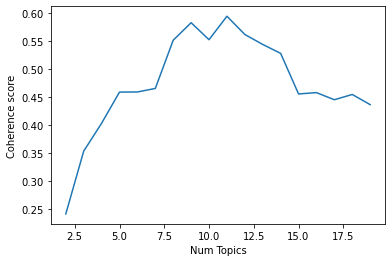

In [28]:
# deterines ideal number of topic. slow and fucked. dont u

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
            id2word=id2word,
            num_topics = num_topics, 
            random_state = 100,
            update_every = eval_every,
            chunksize=chunksize,
            eta = 'auto',
            passes = passes,
            iterations = iterations,
            alpha = 1,
            per_word_topics = True)
        coherencemodel = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=1)

# Elbow for best num_topics. 100% fucked until i figure it out
import matplotlib.pyplot as plt
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.246363  0.010670       1        1  20.577445
7      0.096581  0.216198       2        1  14.177786
0     -0.060838  0.033142       3        1  14.102574
3     -0.117129 -0.166433       4        1  13.832743
6      0.087963 -0.223283       5        1  12.238259
1     -0.095357  0.178285       6        1   9.352945
5      0.037074 -0.087862       7        1   5.874687
8      0.165285 -0.025267       8        1   5.619063
2      0.132784  0.064549       9        1   4.224500, topic_info=              Term       Freq      Total Category  logprob  loglift
207         report  16.000000  16.000000  Default  30.0000  30.0000
218          usage  12.000000  12.000000  Default  29.0000  29.0000
109          order  14.000000  14.000000  Default  28.0000  28.0000
36         invoice  16.000000  16.000000  Default  27.0000  27.0000
61          vendor   5.000000   5.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
194           know   1.131661   8.802731   Topic9  -4.0842   1.1129
267        correct   0.710661   5.991964   Topic9  -4.5494   1.0323
39            item   1.106755  18.919069   Topic9  -4.1064   0.3255
118  anything_else   0.684868   7.631945   Topic9  -4.5864   0.7534
103          today   0.592876  13.704376   Topic9  -4.7306   0.0238

[446 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.358533       able
0         2  0.268900       able
0         4  0.089633       able
0         5  0.089633       able
0         6  0.089633       able
...     ...       ...        ...
63        8  0.275904    worries
224       6  0.722636        yep
368       5  0.692561  yesterday
391       3  0.493262        yet
391       8  0.493262        yet

[599 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 1, 4, 7, 2, 6, 9, 3])